In [6]:
import os
import time

import pandas as pd
import numpy as np
from numpy import random as rng

from PIL import Image
import sys
import re

import theano as th
from theano import tensor as T

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from CSE6240_utilities import plot_confusion_matrix
import matplotlib.pylab as pylab

from scipy.stats import pearsonr

## Read the images and preprocess the images

I feed as much images as possible into my computer memory, for a 8GB laptop, I find 1000 images for each category is a comfortable size (6000). This is not a huge difference from the full data (8973). 

As for preprocessing each image, I resize it to 100 * 100 and convert it gray sacle. 

In [2]:
def readImg(folder, images, image_names, category, i = 0, min_rows = 100, min_cols = 100):
    ''' For reading images as row stacking matrix
    by resizing the image to 100 * 100 and converting the image as gray scale\
    also records the labels of images as image_names
    
    @folder: the name of folder that containing images, should be under the working directory
    @images: list that stores the images
    @image_names: list that stores the labels of images
    @category: category of image
    '''
    
    for base, dirs, files in os.walk ('./' + folder + '/'):
        for filename in files:
            name_JPEG = re.match (r'^(.*)\.JPEG$', filename)
            if name_JPEG:
                filepath = os.path.join (base, filename)
                image = Image.open (filepath, 'r').resize((min_rows, min_cols)).convert("L")
                image = np.array(image).reshape(-1)
                images.append(image)
                image_names.append(0)
                if i >= 999:
                    break
                else:
                    i += 1
                    
    return images, image_names

In [ ]:
# you may change the folders' name to your customization
images = []
image_names = []

images, image_names = readImg("01-Animal", images, image_names, 0)
images, image_names = readImg("02-Fungus", images, image_names, 1)
images, image_names = readImg("03-Geological Formation", images, image_names, 2)
images, image_names = readImg("04-Person", images, image_names, 3)
images, image_names = readImg("05-Plant, flora, plant life", images, image_names, 4)
images, image_names = readImg("06-Sport", images, image_names, 5)

In [3]:
# for future use without preprocssing the data again

np.savetxt("full_data.csv", images, delimiter = ",")
np.savetxt("label.csv", np.array(image_names), delimiter = ",")

In [2]:
class AutoEncoder(object):
    def __init__(self, X, hidden_size, activation_function,
                 output_function):
        #X is the data, an m x n numpy matrix
        #where rows correspond to datapoints
        #and columns correspond to features.
        assert type(X) is np.ndarray
        assert len(X.shape)==2
        self.X=X
        self.X=th.shared(name='X', value=np.asarray(self.X, 
                         dtype=th.config.floatX),borrow=True)
        #The config.floatX and borrow=True stuff is to get this to run
        #fast on the gpu.
        self.n = X.shape[1]
        self.m = X.shape[0]
        #Hidden_size is the number of neurons in the hidden layer, an int.
        assert type(hidden_size) is int
        assert hidden_size > 0
        self.hidden_size = hidden_size
        initial_W = np.asarray(rng.uniform(
                 low = -4 * np.sqrt(6. / (self.hidden_size + self.n)),
                 high = 4 * np.sqrt(6. / (self.hidden_size + self.n)),
                 size = (self.n, self.hidden_size)), dtype=th.config.floatX)
        self.W = th.shared(value=initial_W, name='W', borrow=True)
        self.b1 = th.shared(name='b1', value=np.zeros(shape=(self.hidden_size,),
                            dtype=th.config.floatX),borrow=True)
        self.b2 = th.shared(name='b2', value=np.zeros(shape=(self.n,),
                            dtype=th.config.floatX),borrow=True)
        self.activation_function=activation_function
        self.output_function=output_function
                     
    def train(self, n_epochs = 100, mini_batch_size = 1, learning_rate = 0.1):
        index = T.lscalar()
        x = T.matrix('x')
        params = [self.W, self.b1, self.b2]
        hidden = self.activation_function(T.dot(x, self.W)+self.b1)
        output = T.dot(hidden,T.transpose(self.W))+self.b2
        output = self.output_function(output)
         
        #Use cross-entropy loss.
        L = -T.sum(x*T.log(output) + (1-x)*T.log(1-output), axis=1)
        cost=L.mean()       
        updates=[]
         
        #Return gradient with respect to W, b1, b2.
        gparams = T.grad(cost,params)
         
        #Create a list of 2 tuples for updates.
        for param, gparam in zip(params, gparams):
            updates.append((param, param-learning_rate*gparam))
         
        #Train given a mini-batch of the data.
        train = th.function(inputs=[index], outputs=[cost], updates=updates,
                            givens={x:self.X[index:index + mini_batch_size,:]})

        start_time = time.clock()
        for epoch in xrange(n_epochs):
            print "Epoch:",epoch
            for row in xrange(0,self.m, mini_batch_size):
                train(row)
        end_time = time.clock()
        print "Average time per epoch=", (end_time-start_time)/n_epochs
                    
    def get_hidden(self,data):
        x = T.dmatrix('x')
        hidden = self.activation_function(T.dot(x,self.W)+self.b1)
        transformed_data = th.function(inputs=[x], outputs=[hidden])
        return transformed_data(data)
     
    def get_weights(self):
        return [self.W.get_value(), self.b1.get_value(), self.b2.get_value()]

In [4]:
X = pd.read_csv("full_data.csv", header = None).values

In [10]:
X = X / 255.0

In [11]:
X.shape

(6000, 10000)

In [12]:
activation_function = T.nnet.sigmoid
output_function=activation_function
A = AutoEncoder(X, 1000, activation_function, output_function)
A.train(10, 100) # with 1000 hidden units for 20 epochs with minibatch size of 20
W = np.transpose(A.get_weights()[0])
A.get_hidden(X)[0]

# m_test(X)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Average time per epoch= 48.8907246


array([[  4.46829081e-021,   1.93306859e-062,   1.58601235e-062, ...,
          1.54146766e-035,   1.62861702e-053,   2.92576351e-028],
       [  1.00812802e-019,   1.21570652e-061,   1.07365028e-062, ...,
          7.57522875e-036,   7.24801905e-054,   1.08091149e-035],
       [  4.83862041e-019,   3.16554693e-057,   3.37921843e-056, ...,
          3.10257724e-032,   4.07946574e-049,   2.24488541e-027],
       ..., 
       [  8.02325356e-033,   3.02389510e-102,   2.12744096e-103, ...,
          4.38875161e-058,   4.46762790e-087,   5.67121742e-043],
       [  2.10565810e-019,   1.44404731e-058,   3.33310018e-056, ...,
          1.76610831e-032,   5.26286735e-050,   2.79311921e-053],
       [  1.61440712e-029,   3.56952898e-091,   1.93337911e-090, ...,
          5.38567318e-051,   1.32210190e-076,   2.42411964e-042]])

In [14]:
np.savetxt("Auto-reduced_data.csv", A.get_hidden(X)[0], delimiter = ",")

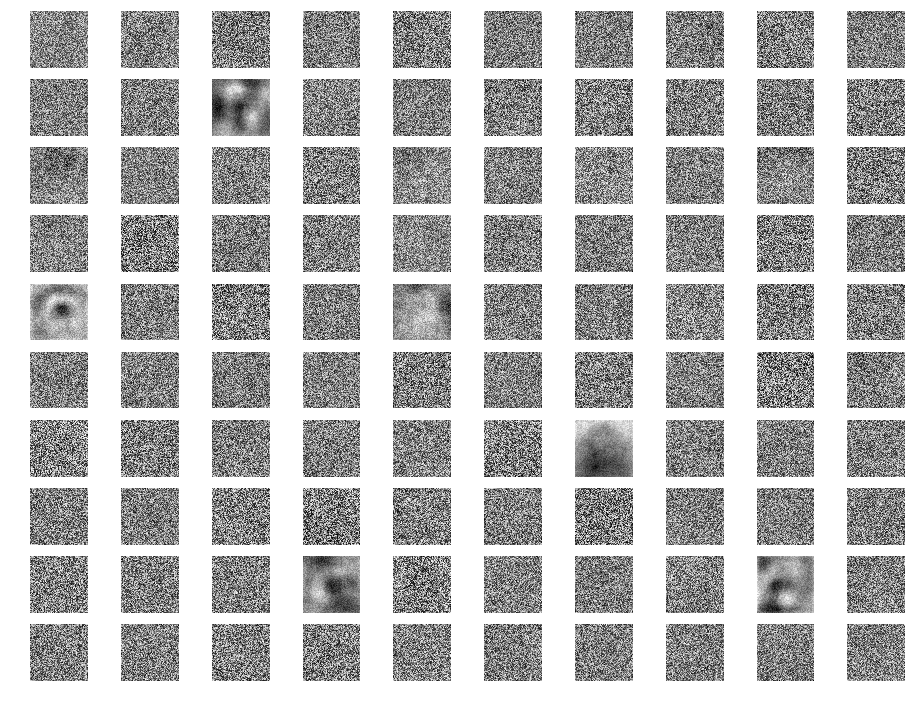

In [13]:
def plot_first_k_numbers(X, k):
    '''quoted from https://triangleinequality.wordpress.com/2014/08/12/theano-autoencoders-and-mnist/
    
    Used for showing the features learned.
    '''
    m = X.shape[0]
    k = min(m,k)
    j = int(round(k / 10.0))
     
    fig, ax = plt.subplots(j,10)
    
    for i in range(k):
        w=X[i,:]       
        w=w.reshape(100, 100)
        ax[i/10, i%10].imshow(w, cmap=plt.cm.gist_yarg,
                      interpolation='nearest', aspect='equal')
        ax[i/10, i%10].axis('off')
 
     
    plt.tick_params(\
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.tick_params(\
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off', 
        right='off',    # ticks along the top edge are off
        labelleft='off')
     
    fig.show()
    
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

plot_first_k_numbers(W,100)

From the above result, we can see that the autoencoder enforced many features to be like noise, while some features retained. I would argue the image (5,1) might be like a bird, (9,4) might be like a rabbit. Since the first 100 weights might captured many features in animal category considering the order of the data, it is not surprising that the learned features showed here indeed look like some animals.

## Prediction

In [3]:
X = pd.read_csv("Auto-reduced_data.csv", header = None).values
y = pd.read_csv("label.csv", header = None).values.reshape(-1)

In [4]:
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
clf.fit(X, y)

y_pred = clf.predict(X)

In [13]:
cm = confusion_matrix(y, y_pred)
print(cm)

[[553  78 133  58  88  90]
 [131 543  90  43 138  55]
 [133  63 635  31  81  57]
 [148 134 165 400  71  82]
 [130 137 106  63 503  61]
 [176  75 168  52 122 407]]


== Autoencoder | euclidean ==


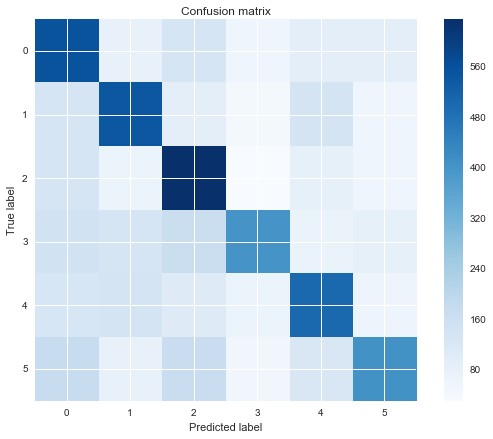

In [14]:
pylab.rcParams['figure.figsize'] = 8, 6
print "== Autoencoder | euclidean =="
plot_confusion_matrix(cm)
print "accuracy = %.4f" % (1.0 * np.sum(np.diag(cm)) / np.sum(np.sum(cm, axis = 0)))

accuracy = 0.5068

### KNN using Pearson Coef and Confusion Matrix

this is super slow!

In [ ]:
def pearson(x, y):
     return 1.0 - pearsonr(x, y)[0] # higher pearson coef is better, opposite to distance

clf = KNeighborsClassifier(n_neighbors = 5, metric = pearson)
clf.fit(X, y)

y_pred = clf.predict(X)

[[558  85 130  51  90  86]
 [128 559  93  40 123  57]
 [139  60 625  36  74  66]
 [143 120 163 423  70  81]
 [130 149 104  67 499  51]
 [167  74 167  48 118 426]]

== Autoencoder | pearson ==
accuracy = 0.5150


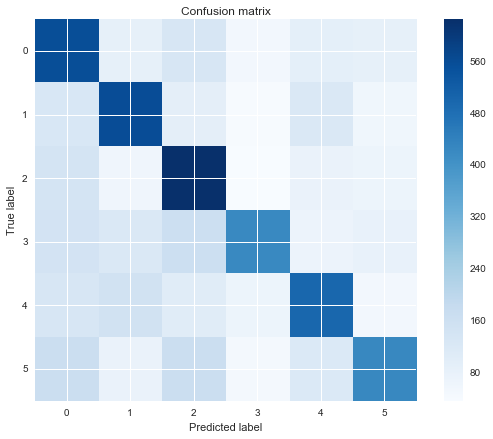

In [13]:
pylab.rcParams['figure.figsize'] = 8, 6
cm = confusion_matrix(y, y_pred)
print(cm)

print "\n== Autoencoder | pearson =="
plot_confusion_matrix(cm)
print "accuracy = %.4f" % (1.0 * np.sum(np.diag(cm)) / np.sum(np.sum(cm, axis = 0)))

### Conclusion

* Ahthough we have not tuned the autoencoder to optimal yet, we can see that the dimensional reduction has encoded image features effectively. As you can see in the diffusion matrix, the diagnal elements dominate the subdiagnal and superdiagnal elements, which indicates the permance is not bad.

* When using Euclidean distance
<img src="embed_pictures/auto-eu.PNG", width = 200>
$$accuracy = \frac{Tr(cm)}{\sum\sum{cm}} = 0.5068$$
* When using Pearson coef
<img src="embed_pictures/auto-pearson.PNG", width = 200>
$$accuracy = \frac{Tr(cm)}{\sum\sum{cm}} = 0.5150$$

* We can see that in this example that dimensional reduced by autoencoder, pearson-based knn performs slightly better than euclidean-based knn. However, pearson-based knn is very slow compared to euclidean-based knn. So I would argue that euclidean-based knn is still the better choice. Since pearson-based knn takes too much runtime (~1hr), in the following implementation, I would just report the classification result using euclidean-based knn.